In [1]:
import pandas as pd
import numpy as np
import sqlite3
import datetime
import sklearn
import sqlalchemy as sa
from tqdm import tqdm_notebook
import itertools
import pickle
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn import metrics

In [2]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

import operator
import gc

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

In [4]:
%matplotlib inline

---

для обучения берем только данные с 20171029 по 20171128<br>
для теста с 20171129 по 20171205

In [5]:
%%time
!mkdir -p ../../data/predictions/
train_df = pd.read_feather('../../data/combined_dataset/train_v1.fth')
test_df = pd.read_feather('../../data/combined_dataset/test_v1.fth')

CPU times: user 1.67 s, sys: 5.07 s, total: 6.74 s
Wall time: 14.7 s


In [6]:
%%time
drop_cols = ['event_id', 'user_id', 'short_date', 'event_time']
train_df.drop(columns = drop_cols, inplace = True)
test_df.drop(columns = drop_cols, inplace = True)

CPU times: user 1.13 s, sys: 3.42 s, total: 4.55 s
Wall time: 4.53 s


In [7]:
train_df = train_df.loc[train_df['label'].isin([0, 1])].copy()

параметры для xgboost были подобраны в другом ноутбуке через GridSearch

In [8]:
model = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
                          gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
                          min_child_weight=1, missing=None, n_estimators=200,
                          objective='binary:logistic', reg_alpha=8, reg_lambda=1,
                          scale_pos_weight=1, seed=0, silent=True, subsample=0.6, n_jobs=16)

In [9]:
%%time
predictor = model.fit(train_df.drop('label', axis = 1), train_df['label'])

CPU times: user 1h 39min 5s, sys: 20.5 s, total: 1h 39min 25s
Wall time: 8min 31s


some sanity checks

In [10]:
train_proba = predictor.predict_proba(train_df.drop('label', axis = 1))

Обычный ROC-AUC: 0.984947000484716


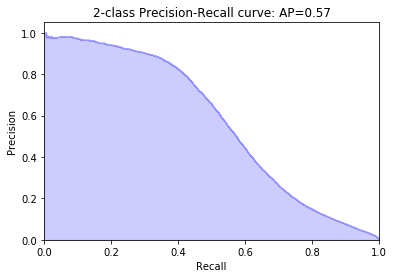

PR-curve AUC 0.5730626955234419


In [15]:
y_train = [1 if x == 1 else 0 for x in train_df['label']]
preds = train_proba[:, 1]

print(f'Обычный ROC-AUC: {roc_auc_score(y_train, preds)}')
average_precision = average_precision_score(y_train, preds)
precision, recall, thresholds = precision_recall_curve(y_train, preds)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

print(f'PR-curve AUC {metrics.auc(recall, precision)}')

теперь собственно делаем предсказания

In [19]:
set(train_df.drop('label', axis = 1).columns) - set(test_df.columns)

set()

In [22]:
test_proba = predictor.predict_proba(test_df[train_df.drop('label', axis = 1).columns.values])[:, 1]

In [26]:
test_df.columns.tolist()

['amount',
 'client_age',
 'cat_new_ip',
 'cat_new_prov',
 'channel_op',
 'op_type',
 'cumulative_sum_total',
 'data_i_120',
 'data_i_154',
 'cdf_s_127',
 'cdf_s_129',
 'cdf_s_130',
 'cdf_s_133',
 'cdf_s_134',
 'cdf_s_135',
 'know_recip_card_age',
 'recip_card_age',
 'one_region',
 'log_amount',
 'ip_isp',
 'amnt2chnls',
 'is_mts',
 'is_beeline',
 'is_megafon',
 'is_tele2',
 'is_ru_mobile',
 'ip_contry_ru',
 'ip_contry_kz',
 'ip_contry_ua',
 'ip_contry_br',
 'ip_contry_tr',
 'ip_contry_th',
 'ip_contry_null',
 'ip_contry_is_unknown',
 'ip_contry_is_other',
 'hardwareid_notnull',
 'user_agent_string_hash_notnull',
 'browser_plugins_hash_notnull',
 'screen_hash_notnull',
 'user_id_MBK',
 'user_id_VSP',
 'user_id_CRM',
 'user_id_IVR',
 'user_id_other',
 'user_id_digit_only',
 'channel_indicator_desc_is_MOBILEAPI',
 'channel_indicator_desc_is_WEBAPI',
 'channel_indicator_desc_is_ATMAPI',
 'channel_indicator_desc_is_MBK',
 'channel_indicator_desc_is_other',
 'event_hour',
 'event_hour_night

In [27]:
test_df_raw = pd.read_feather('../../data/combined_dataset/test_v1.fth')

In [31]:
final = test_df_raw[['event_id']].copy()
final['label_1_prob'] = test_proba

In [32]:
final.head(5)

,event_id,label_1_prob
0,e264-:4fbd8d52061:1c81f046_TRX,0.055129
1,54e7:e19e2b52061:3cbd98c1-_TRX,0.028082
2,7581-:454f5d52061:e838eec1_TRX,0.038442
3,5ec-:763a2f62061:7ecf1c37_TRX,0.035923
4,cd72:c03d2b52061:d95998d3_TRX,0.049398


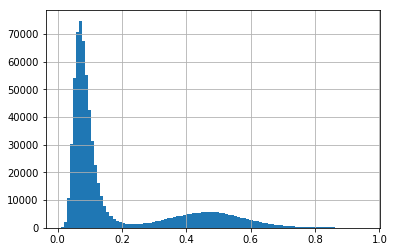

In [34]:
final['label_1_prob'].hist(bins = 100)

In [35]:
final.to_csv('../../data/predictions/test_prediction_team1.csv', index = None)